# 关联二维矩阵

## 时间修正

由于不同幅度的信号的上升时间不一样，定时有walk现象，需要进行修正。一般幅度较大的信号的walk较小，所以选择幅度较大的信号可以认为近似忽略walk。

In [1]:
TFile *ipf = new TFile("../data/eurica.root", "read");
TTree *tree = (TTree*)ipf->Get("tree");
TCanvas *c1 = new TCanvas;

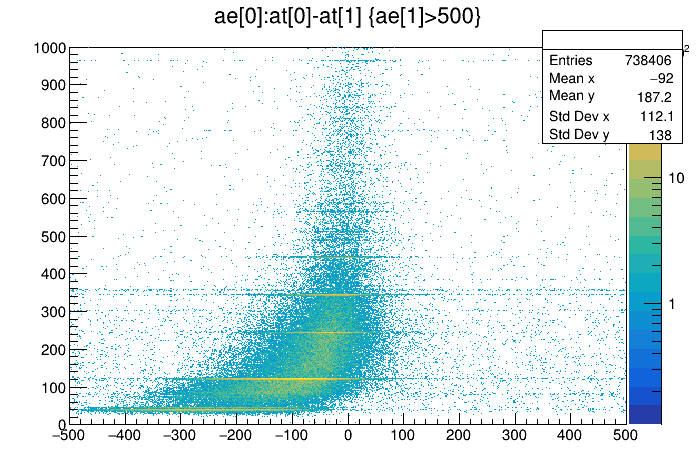

In [2]:
tree->Draw("ae[0]:at[0]-at[1]>>(500, -500, 500, 1000, 0, 1000)", "ae[1]>500", "colz");
c1->SetLogz();
c1->Draw();

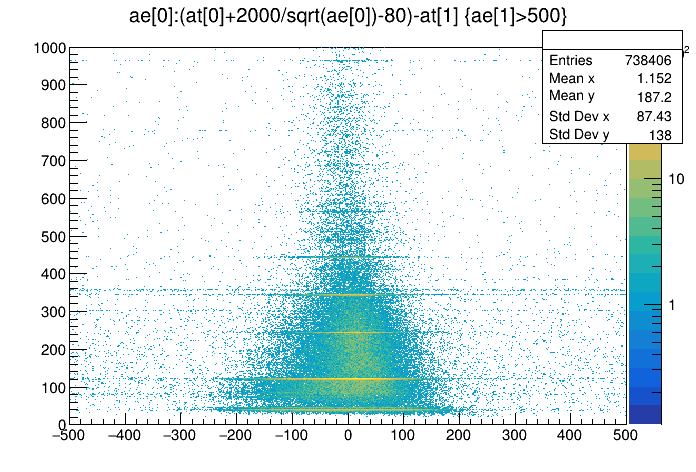

In [3]:
tree->Draw("ae[0]:(at[0]+2000/sqrt(ae[0])-80)-at[1]>>(500, -500, 500, 1000, 0, 1000)", "ae[1]>500", "colz");
c1->Draw();

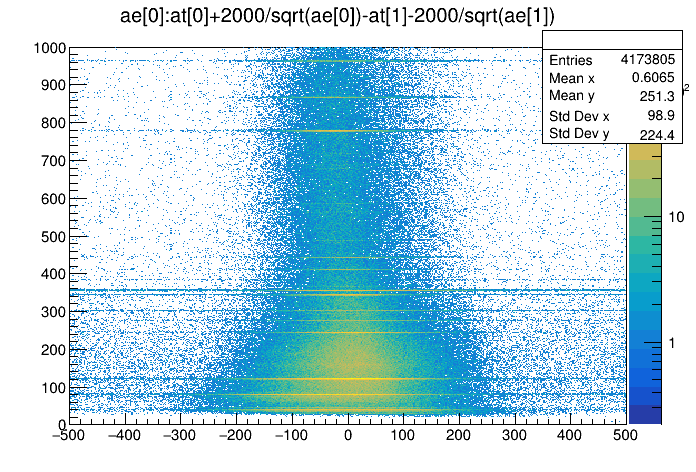

In [4]:
tree->Draw("ae[0]:at[0]+2000/sqrt(ae[0])-at[1]-2000/sqrt(ae[1])>>(500, -500, 500, 1000, 0, 1000)", "", "colz");
c1->Draw();

选择修正公式为 $t' = t + 2000/\sqrt{e} - 80$ 比较符合

## 生成二维关联矩阵

```c++
int main() {
	// input data
	Int_t ahit;
	Int_t aid[16];
	Double_t ae[16], at[16];
	// input file and tree
	TFile *ipf = new TFile("../data/eurica.root", "read");
	TTree *ipt = (TTree*)ipf->Get("tree");
	ipt->SetBranchAddress("ahit", &ahit);
	ipt->SetBranchAddress("aid", aid);
	ipt->SetBranchAddress("ae", ae);
	ipt->SetBranchAddress("at", at);

	// output data
	Int_t achit;
	Int_t aidx[256], aidy[256];
	Double_t aex[256], aey[256], atx[256], aty[256];
	// oputput file and tree
	TFile *opf = new TFile("../data/ggc.root", "recreate");
	TTree *opt = new TTree("tree", "gamma-gamma coincidence tree");
	opt->Branch("achit", &achit, "achit/I");
	opt->Branch("aidx", aidx, "aidx[achit]/I");
	opt->Branch("aidy", aidy, "aidy[achit]/I");
	opt->Branch("aex", aex, "aex[achit]/D");
	opt->Branch("aey", aey, "aey[achit]/D");
	opt->Branch("atx", atx, "atx[achit]/D");
	opt->Branch("aty", aty, "aty[achit]/D");
	// output matrix
	TH2D *hgg = new TH2D("hgg", "gamma-gamma matrix", 1500, 0, 1500, 1500, 0, 1500);


	printf("processing   0%%");
	fflush(stdout);
	Long64_t nentry = ipt->GetEntries();
	Long64_t nentry100 = nentry / 100;
	for (Long64_t jentry = 0; jentry != nentry; ++jentry) {
		ipt->GetEntry(jentry);
		achit = 0;
		for (int i = 0; i != ahit; ++i) {
			for (int j = 0; j != ahit; ++j) {
				if (i==j) continue;
				atx[achit] = at[i] + 2000.0 / sqrt(ae[i]) - 80.0;
				aty[achit] = at[j] + 2000.0 / sqrt(ae[j]) - 80.0;
				if (abs(atx[achit]-aty[achit]) > 1000) continue;
				aidx[achit] = aid[i];
				aidy[achit] = aid[j];
				aex[achit] = ae[i];
				aey[achit] = ae[j];

				if (abs(atx[achit]-aty[achit]) < 200) {
					hgg->Fill(aex[achit], aey[achit]);
				}
				achit++;
			}
		}
		if (achit) opt->Fill();

		if (jentry % nentry100) {
			printf("\b\b\b\b%3lld%%", (jentry+1)/nentry100);
			fflush(stdout);
		}
	}

	opt->Write();
	hgg->Write();
	opf->Close();
	ipf->Close();

	printf("\b\b\b\b100%%\n");
	return 0;
}
```
新生成的树相当于只有两个探测器x和y，每个探测器记录其能量、时间、id信息。